<a href="https://colab.research.google.com/github/sahil3Vedi/digit-recogniser-py/blob/master/Deep_Learning_on_MNIST_without_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [313]:
#declaring all the dependencies NO KERAS OR TENSORFLOW
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
from google.colab import drive
from math import e
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Neural Network is Trained in 4 Stages:

1) Network recieves input from model
FUNCTION: NN.getInput(model.inputList)
VARIABLES INVOLVED: NN.layers[0].inputVals

2) Network activates one layer after the other.
FUNCTION: NN.activate(activationFunction)
VARIABLES INVOLVED: NN.layers[i].inputVals, NN.layers[i].activations, NN.layers[i].activDerivates, NN.layers[i].layerWeights, NN.layers[i].bias, NN.layers[i].biasWeights

3) Model calculates cost from the target value of input data and answer provided by network.
FUNCTION: model.getCost(NN)
VARIABLES INVOLVED: NN.layers[-1].activations, NN.layers[-1].forwardError, model.cost

4) Network readjusts the weights based on the cost and error information.
FUNCTION: NN.backpropagate()
VARIABLES INVOLVED: NN.layers[i].forwardError, NN.layers[i].diffWeights, NN.layers[i].diffBias, NN.layers[i-1].activations, NN.layers[i-1].forwardError

In [0]:
class neuralNetwork:
  layers=[]
  finalError=[]
  inputElem=0
  hiddenElem=0
  outputElem=0
  
  #When a neural network is declared 
  def __init__(self):
    self.inputElem=784
    self.outputElem=10
    self.hiddenElem=30
    
    inputLayer = layer(self.inputElem,"normalize",None)
    self.layers.append(inputLayer)
    
    temp = layer(self.hiddenElem,"tanH",self.layers[0])
    self.layers.append(temp)
    temp = layer(self.hiddenElem,"tanH",self.layers[1])
    self.layers.append(temp)
    temp = layer(self.hiddenElem,"tanH",self.layers[2])
    self.layers.append(temp)
    
    outputLayer = layer(self.outputElem,"softMax",self.layers[3])
    self.layers.append(outputLayer)
    #TOTAL 5 LAYERS
    print("Neural Network Initialised...")
    
  def getInput(self,i):
    self.layers[0].inputVals=i
    
  def dropout(self,x,y):
    stu=[]
    tempp=[]
    tempq=[]
    for i in range(len(x)):
      k=np.random.random_sample()
      m=x[i]
      n=y[i]
      if k<0:
        tempp.append(0)
        tempq.append(0)
      else:
        tempp.append(m)
        tempq.append(n)
    stu.append(tempp)
    stu.append(tempq)
    return stu
    
  def activate(self):
    for i in range(0,len(self.layers)):
      temp=self.layers[i].inputVals
      activation=self.layers[i].activation
      
      if (activation=="normalize"):#typically used for the input layer. if you ask me it makes perfect sense to treat normalisation as input layer activation.
        temp2=[(-1+(int(x)*2)/255) for x in temp]
        temp3=temp2 #this is because normalise is only being used on input layer where we dont need any back prop hence no need to calculate derivative.
      
      if (activation=="ReLU"):
        temp2=[]
        temp3=[]
        for x in temp:
          if (x>0):
            y=x
            z=1
          else:
            y=0.0000001*x
            z=0.0000001
          temp3.append(z)
          temp2.append(y)
          
      if (activation=="tanH"):
        temp2=[]
        temp3=[]
        for x in temp:
          a=e**(0.5*x)
          b=e**(-0.5*x)
          temp2.append((a-b)/(a+b))
        for y in temp2:
          temp3.append(0.5*(1-(y**2)))
          
      if (activation=="softMax"):
        evec=[e**x for x in temp]
        esum=np.sum(evec)
        temp2=[y/esum for y in evec]
        temp3=[q*(1-q) for q in temp2]
        
      if (activation=="tanH" or activation=="ReLU"):  
        stub=self.dropout(temp2,temp3)
      else:
        stub=[]
        stub.append(temp2)
        stub.append(temp3)
      
      self.layers[i].activations=stub[0]
      self.layers[i].activDerivatives=stub[1]
      
      if(i!=len(self.layers)-1):#this is because we dont need to feed forward beyond the output layer.
        self.layers[i].feedForward(self.layers[i+1])
  
  def backpropagate(self):
    for i in range(len(self.layers)):
      ind=-i-1
      if(i!=len(self.layers)-1):
        self.layers[ind].updateWeights(self.layers[ind-1])

In [0]:
class model:
  epoch=0
  learningRate=0.01
  cost=0
  target=0
  inputFile=[]
  trainingEntries=0
  accuracy=0
  accuracies=[]
  costs=[]
  epochs=[]
  
  def plotLoss(self):
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(self.epochs,self.accuracies)
    plt.show()
    
  def response(self,NN):
    #updating learning rate
    self.learningRate=(self.cost)*(0.1)/(0.449)
    maxI=max(NN.layers[-1].activations)
    indX=NN.layers[-1].activations.index(maxI)
    if(str(self.target)==str(indX)):
      self.accuracy+=1
    self.epoch+=1
    if(self.epoch%5000==0):
      self.plotLoss()
    if(self.epoch%500==0):
      print("Epoch: " + str(self.epoch) + " Cost: " + str(self.cost) + " Target: " + str((self.target)) + " Answer : " + str(indX))
      print(NN.layers[-3].activations)
      print("Accuracy: " + str(self.accuracy))
    if(self.epoch%100==0):
      #Adding accuracy cost and epoch for plotting.
      self.costs.append(self.cost)
      self.accuracies.append(self.accuracy)
      self.epochs.append(self.epoch)
      self.accuracy=0
  
  def getInput(self,inputFile):
    with open(inputFile) as csvFile:
      csvReader = csv.reader(csvFile)
      self.inputFile = list(csvReader)
      self.trainingEntries = len(self.inputFile)-1  #n-1 because first row is header row
      print("Total entries excluding header: " + str(self.trainingEntries) + " rows")
      
  def getCost(self,NN):
    targetVector=[]
    for i in range(10):
      if (str(i)==str(self.target)):
        targetVector.append(1)
      else:
        targetVector.append(0)
    output=NN.layers[-1].activations
    error=[x-y for (x,y) in zip(output,targetVector)]
    self.cost=0.5*(np.sum(np.square(error)))
    NN.layers[-1].forwardError=error
      
  def trainNetwork(self,NN):
    inputList=self.inputFile
    inputList.pop(0)
    for i in inputList:
      self.target=i[0]
      i.pop(0)
      NN.getInput(i)
      NN.activate()
      self.getCost(NN)
      NN.backpropagate()
      Model.response(NN)
      
  def invCross(self,l1,l2): #this is the ONLY part that
    temp=[]
    for x in l1:
      temptemp=[]
      for y in l2:
        temptemp.append(x*y)
      temp.append(temptemp)
    return temp
      

In [0]:
class layer:
  numberElements=0
  bias=0
  activation="default"
  inputVals=[]
  activations=[]
  activDerivatives=[]
  forwardError=[]
  layerWeights=[]
  biasWeights=[]
  
  #When a layer is declared
  def __init__(self,no_of_elements,activation,previousLayer):
    self.numberElements=no_of_elements
    self.bias=0.1
    self.activation=activation
    #Initialising the Weight Matrix
    temp=[]
    if(previousLayer!=None):
      for i in range(previousLayer.numberElements):
        temptemp=[]
        for j in range(self.numberElements):
          temptemp.append(np.tanh(0.3*(np.random.random_sample()-0.5)))
        temp.append(temptemp)
    self.layerWeights=temp
    #Initialising the Bias Matrix
    self.biasWeights=[]
    for i in range(self.numberElements):
      self.biasWeights.append(np.tanh(0.3*(np.random.random_sample()-0.5)))
      
  def feedForward(self,nextLayer):
    tempbias=self.bias
    biasVec=nextLayer.biasWeights
    temp2=np.matmul(self.activations,nextLayer.layerWeights)
    temp3=np.multiply(tempbias,biasVec)
    nextLayer.inputVals=[x+y for (x,y) in zip(temp2,temp3)]
    
  def updateWeights(self,prevLayer):
    #declaring the Differential diagonal matrix
    dmx=[]
    for i in range(self.numberElements):
      dtemp=[]
      oi=self.activations[i]
      for j in range(self.numberElements):
        if(i==j):
          dtemp.append(oi*(1-oi))
        else:
          dtemp.append(0)
      dmx.append(dtemp)
    #declaring do vector
    dovec=np.matmul(dmx,self.forwardError)
    wmx=Model.invCross(dovec,prevLayer.activations)
    bvec=np.multiply((self.bias*Model.learningRate),dovec)
    wMx=np.multiply(Model.learningRate,wmx)
    tempW=np.subtract(self.layerWeights,np.transpose(wMx))
    tempB=np.subtract(self.biasWeights,bvec)
    self.layerWeights=tempW
    prevLayer.forwardError=np.matmul(self.layerWeights,dovec)
    
    

Total entries excluding header: 42000 rows
Neural Network Initialised...
Epoch: 500 Cost: 0.447762214208734 Target: 9 Answer : 9
[0.01238207838197073, -0.044876324457389545, -0.02144398912614646, -0.029720747022820994, 0.022731497971102438, -0.03331234428376916, -0.16350978149854464, -0.12080711764390986, -0.12340650800505787, -0.05668441712793386, -0.32081248377705135, 0.29306102315783616, 0.07827820294373429, 0.16427619660778728, -0.11389919802597076, 0.03028831381856354, -0.02827373766628712, 0.11254268561639734, -0.08535118103312958, -0.31474712563799473, 0.08972061111080482, -0.16221380501901964, -0.1259058192191992, 0.002062268492699384, 0.16098575524679679, -0.03548707356055268, -0.36646961485747653, -0.0521514735067577, -0.09178709982598773, -0.25771148997785953]
Accuracy: 12
Epoch: 1000 Cost: 0.4497577772693639 Target: 4 Answer : 2
[-0.2565717723375079, 0.17513221543456992, -0.17736483534532624, 0.1285487472079335, -0.10482853278992489, -0.2577355134744736, 0.13754748963911817

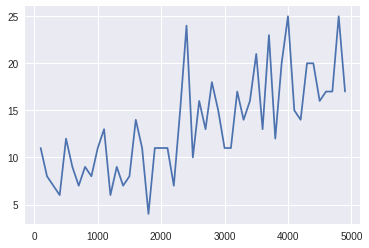

Epoch: 5000 Cost: 0.44858667476913944 Target: 9 Answer : 4
[-0.0791430489691359, 0.13927778989720271, -0.18334209708592633, 0.17786275821252592, -0.2689327496216679, -0.14687332389585023, 0.2780645028573253, -0.2953431283540672, -0.35182955138267236, -0.33944066309463644, -0.2956515250404664, 0.3096469808292351, -0.1591119923992805, 0.1973623257946497, 0.05484339254634639, -0.046408836514307626, -0.152894299653326, 0.05301880448077905, -0.17812402714908554, -0.1613611175465286, 0.04502951033796565, -0.31341574149458024, 0.10054828487568958, -0.009393117686170864, -0.1730365523443053, 0.07727094855743093, -0.0996679663627342, -0.15464868910855925, -0.03414843313293077, -0.20071201313115417]
Accuracy: 17
Epoch: 5500 Cost: 0.44718953381306503 Target: 4 Answer : 1
[-0.23588681572322645, 0.08472848554557617, -0.15084473239931329, 0.11019616554796917, -0.2012448231266977, -0.21175777821834604, 0.01597569617853651, -0.36999754722369904, -0.2569567494602536, -0.36532952963721704, -0.3968241015

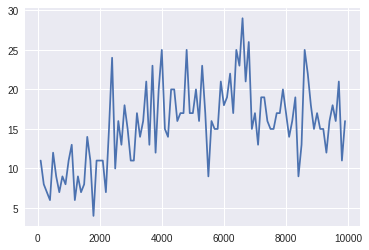

Epoch: 10000 Cost: 0.4467989656257018 Target: 9 Answer : 4
[-0.1319229439389269, 0.14466219676310724, -0.27901359957527677, 0.0803818072437554, -0.06028342206391077, -0.13646118627113316, 0.05048376075999438, -0.18092586753746678, -0.17502507257951086, -0.001082824992599527, -0.40448901404160637, 0.19828326455335493, 0.060462118832615236, 0.18138743702386584, 0.03960404659011613, -0.00029411477179487394, -0.18852669829037605, -0.08721478232016965, -0.19720214328029687, -0.1661391305864063, -0.11029709884245868, -0.1870504381423285, -0.10212259094704942, 0.029151172177093076, -0.08876274076366474, 0.15083284922668438, -0.21132725068383407, -0.06740946623681178, 0.01684569428108004, -0.07882236723547908]
Accuracy: 18
Epoch: 10500 Cost: 0.44672708659568505 Target: 9 Answer : 1
[-0.03475460730498302, 0.15013345508885498, -0.17479445594996063, 0.057338432538875383, -0.05518572476812471, -0.17852805597097815, 0.13867100059659046, -0.2617749801114406, -0.36346334186584317, -0.2591779478205104

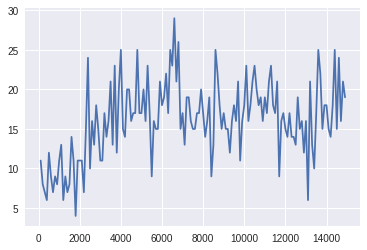

Epoch: 15000 Cost: 0.45216626343301036 Target: 6 Answer : 1
[0.013586337455502435, -0.022863422230434482, -0.11063314138585241, 0.15030509008777598, -0.1264057961248821, -0.00164523300856286, 0.028874407538155813, -0.13580562978596492, -0.20455762610285866, -0.3578913136225062, -0.22330411665546823, 0.31813586683951517, -0.251720951803805, 0.28429613815089116, 0.12469746973925726, 0.05043294448312064, -0.06624490740421017, -0.10957604839055529, -0.06201138737061545, -0.06656282155973561, -0.03819626263900218, -0.04033174190089789, 0.017062269290465792, 0.25091752684703633, -0.0890425510828674, 0.17526554189284474, 0.12853362266977045, 0.019207478392660023, -0.12787867352123428, -0.1339443567129642]
Accuracy: 21
Epoch: 15500 Cost: 0.44528568097203325 Target: 2 Answer : 1
[-0.07469071219949693, 0.08207796931996296, -0.08340773961453946, 0.14782592577248596, 0.010057533898013667, -0.013766491332705707, -0.0012436885145532762, -0.13311567012541925, -0.1823097408664534, -0.25112595007266253

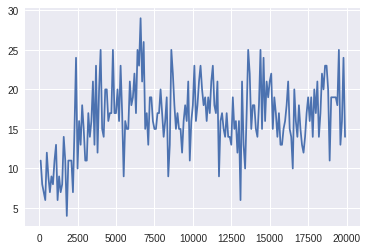

Epoch: 20000 Cost: 0.44503304223372425 Target: 7 Answer : 1
[0.08663739175411146, 0.04708746649476622, -0.048005859465679396, 0.034173158143143076, -0.0008492190228661582, -0.040702507442315905, 0.06449773579771514, -0.09308532218055499, -0.2309083142627725, -0.07497256461620526, -0.2751811173976346, 0.5163553732074818, -0.1793204875802697, 0.24449333162795042, 0.10707432228353383, 0.13243306370315608, -0.23179299559557773, -0.14946752492894758, -0.08235184688802388, -0.14468643654936694, -0.04703178434657348, -0.06117945762186265, -0.1188823440715908, 0.22949556441120467, 0.09609293346321181, -0.06118389109119065, 0.09261781592732818, -0.10638041241724867, -0.017648575707614182, -0.13773919266335252]
Accuracy: 14
Epoch: 20500 Cost: 0.4483922723901386 Target: 6 Answer : 1
[0.01975934408373087, 0.15460231940056185, -0.10657753869059519, 0.21752447145020248, 0.2393925914568669, 0.1401059167689242, -0.05468905358630217, 0.06459148209665863, -0.10715862109198478, -0.09357970423893783, -0.2

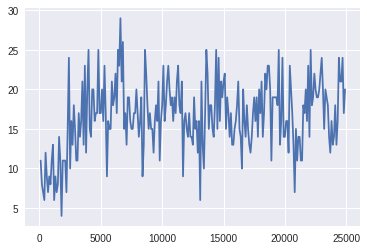

Epoch: 25000 Cost: 0.45669222135661225 Target: 5 Answer : 1
[0.05368614810066769, 0.017175689937061648, -0.07188105620692294, 0.13972915344938006, -0.017672327515036685, 0.036741398600383265, 0.028949928096220805, -0.20139752076727135, -0.2216406356735055, -0.12923536064811658, -0.10494078790359085, 0.5405091252535384, -0.11339865002295536, 0.3265135605918652, 0.24831505338945017, 0.07266032053605194, -0.21085636355971113, -0.15100379976920858, -0.1320410978372859, 0.029449409295050896, -0.010810990789309154, 0.14113408699232402, -0.02117586809019707, 0.28957327783494724, 0.12875634484724335, 0.10118812899779213, 0.0046315470962220206, 0.05082052125924837, 0.04059105586143147, -0.086586707832489]
Accuracy: 27
Epoch: 25500 Cost: 0.4496894744911886 Target: 7 Answer : 1
[0.10643817874806262, 0.004417186765031932, -0.1477722061632363, 0.2384386246524773, 0.1714591923424815, 0.11292247312777577, -0.1009299173823927, 0.04725222001387277, -0.16827838786647314, 0.08671235422949387, -0.08151103

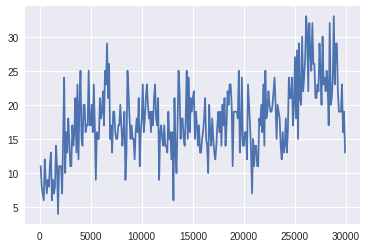

Epoch: 30000 Cost: 0.439052054571644 Target: 0 Answer : 0
[-0.044329589910686036, -0.03886414921754058, 0.25144354912088734, 0.2403621445471048, 0.28434284801904536, 0.18486401229349617, 0.07223137023473378, -0.05816720377116462, -0.03959879726149339, 0.2124675072118797, -0.0706459380842601, 0.45752449273236656, -0.07256033178814493, 0.37471061040844084, 0.09480508673261308, -0.19959037501052948, -0.015377864769357437, 0.04746796513956438, 0.020209541919835837, 0.0926156501613592, 0.22752685112907667, 0.011285417360665963, 0.10531533807701376, 0.19052375629516255, 0.10469294413355049, -0.07940535596235641, -0.04376520287154399, -0.10373224974416505, -0.134840828977419, -0.10269466464092299]
Accuracy: 14
Epoch: 30500 Cost: 0.44606411885323105 Target: 8 Answer : 1
[0.09162012802366648, -0.09542720789709074, 0.08794748814769593, 0.3627595612232322, 0.21586516985938287, 0.10225286291723638, 0.16906455545824658, 0.06494861896145937, -0.06565489400664498, 0.17201788044381347, 0.0069117608227

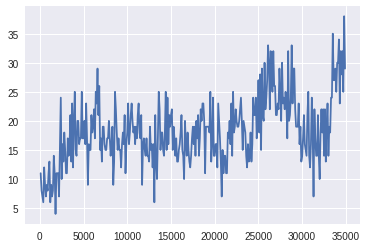

Epoch: 35000 Cost: 0.17165812436826638 Target: 0 Answer : 0
[-0.07811299294389155, 0.06687563478913512, 0.8621757023741549, 0.5505131885190755, 0.1943946364232402, 0.16906093559572044, 0.4645161400124816, -0.20959251326358497, 0.2803116394810965, 0.5830701340712244, -0.10309008559168764, 0.31370963051852196, -0.028956773384950358, 0.5972100353958854, -0.09821050134541567, 0.11952486670524552, 0.48745783167814594, 0.3715944581696431, 0.2676787193903655, 0.6022290706403416, 0.465500840013683, 0.12217203545804518, 0.39368117383427564, 0.1684146881932834, 0.42188559769677386, -0.05114375063918949, -0.14233083596908683, 0.4005270678452431, -0.145897166327645, -0.019340475480640596]
Accuracy: 37
Epoch: 35500 Cost: 0.3739892238098698 Target: 2 Answer : 6
[0.5257854572127935, -0.10016468636437476, 0.8343994261687585, 0.8824739511153442, 0.1408491150175245, 0.3843558329066254, 0.12123207758633799, 0.0511769077866286, 0.3759123075757314, 0.3283680345760314, 0.09245749325908457, -0.21211882692133

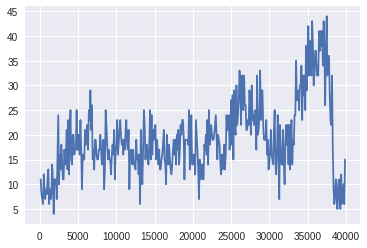

Epoch: 40000 Cost: 0.4184689977950088 Target: 3 Answer : 8
[-0.19133424692283002, 0.33301842568384654, 0.3913155595843368, 0.5223131785565345, 0.401020235153075, 0.39335093212218614, 0.5988004146303655, 0.3693230663475273, 0.4585888741838942, 0.8158575601469681, -0.9203700265708964, 0.4510463308543721, 0.25512544898976774, 0.7258058090076945, -0.3635696464792624, 0.3982495778826908, -0.11761759001307075, 0.4899287726261591, 0.6006218359759528, 0.6568529428216614, 0.5718636381452183, 0.22595634652903782, 0.31175194241199694, 0.3469144236224572, -0.6277088527452476, 0.59623555225944, 0.4741015500129589, -0.37454232754071803, 0.4141481236870876, 0.49099638086290737]
Accuracy: 10
Epoch: 40500 Cost: 0.43316804673540166 Target: 4 Answer : 5
[-0.8025768717762656, 0.38972363840712027, -0.7732862527439167, -0.15256534556830295, 0.32690906411061876, 0.3173145422977614, 0.6271735988895568, 0.3704246057434026, -0.1236159290519722, 0.8809734192341444, -0.9770328600632894, 0.8407187552650758, 0.3581

In [317]:
#-----MAIN FUNCTION-----

Model = model()
inputFile='drive/My Drive/MNIST Image CSV/train.csv'
Model.getInput(inputFile)

NN = neuralNetwork()
Model.trainNetwork(NN)